In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

## DATABASE CONNECTION

In [2]:
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


## IMPORT DATA BY HOURS DAY

In [4]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

print(weather.head())
print(weather.shape)


         date  hour_of_day  avg_temperature  avg_dewpoint  \
0  2014-01-01          0.0         5.400000      3.845455   
1  2014-01-01          1.0         5.940000      4.150000   
2  2014-01-01          2.0         5.609091      3.681818   
3  2014-01-01          3.0         5.072727      3.145455   
4  2014-01-01          4.0         5.100000      3.118182   

   avg_relative_humidity  avg_precipitation  avg_snowfall  avg_wind_direction  \
0              90.818182           0.045455           0.0          208.181818   
1              89.300000           0.080000           0.0          210.000000   
2              88.454545           0.009091           0.0          212.727273   
3              88.545455           0.000000           0.0          206.363636   
4              88.000000           0.009091           0.0          200.000000   

   avg_wind_speed  avg_pressure  
0       18.327273   1009.318187  
1       18.360000   1009.379999  
2       18.000000   1009.945451  
3       17

In [ ]:
query = """
    SELECT 
        t.departure_date AS date,
        EXTRACT(HOUR FROM t.real_time_departure) AS hour_of_day,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date, hour_of_day
    ORDER BY t.departure_date, hour_of_day;
"""

train_data = pd.read_sql(sqla.text(query), connection)

print(train_data.head())
print(train_data.shape)

In [5]:
query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)

print(type_day.head())
print(type_day.shape)

         date  holiday  weekend  day_after_rest
0  2014-01-01        2    False           False
1  2014-01-02        1    False           False
2  2014-01-03        1    False           False
3  2014-01-04        1     True           False
4  2014-01-05        1     True           False
(4018, 4)


In [8]:
#Merging
merged_df = train_data.merge(weather, on=["date", "hour_of_day"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

#Doing this for better dealing with date
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)

print(merged_df.shape)
print(merged_df.head())

(90390, 16)
   holiday  weekend  day_after_rest  hour_of_day  avg_delay_arrival  \
0        2    False           False          0.0         294.669767   
1        2    False           False          1.0          22.523810   
2        2    False           False          4.0          15.243902   
3        2    False           False          5.0          21.412399   
4        2    False           False          6.0          28.685057   

   avg_delay_departure  avg_temperature  avg_dewpoint  avg_relative_humidity  \
0           342.465116         5.400000      3.845455              90.818182   
1            47.571429         5.940000      4.150000              89.300000   
2            29.804878         5.100000      3.118182              88.000000   
3            33.870620         4.945455      2.981818              88.181818   
4            41.846743         4.909091      2.918182              88.000000   

   avg_precipitation  avg_snowfall  avg_wind_direction  avg_wind_speed  \
0     

## Methods for regression

In [6]:
#Importing from sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold



## Only with the weather

In [7]:
def dummy_train(xtrain,xtest,ytrain,ytest,model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print("Model",model)
    print("MSE: ",mean_squared_error(ytest,ypred))
    print("MAE: ",mean_absolute_error(ytest,ypred))
    print("R2: ",r2_score(ytest,ypred))

In [8]:
def model_test(xtrain,xtest,ytrain,ytest):
    dummy_train(xtrain,xtest,ytrain,ytest,RandomForestRegressor())
    dummy_train(xtrain,xtest,ytrain,ytest,LinearRegression())
    dummy_train(xtrain,xtest,ytrain,ytest,Lasso())
    dummy_train(xtrain,xtest,ytrain,ytest,Ridge())
    dummy_train(xtrain,xtest,ytrain,ytest,SVR())
    dummy_train(xtrain,xtest,ytrain,ytest,DecisionTreeRegressor())
    dummy_train(xtrain,xtest,ytrain,ytest,KNeighborsRegressor())


In [ ]:
x_weather_hours = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_weather_hours = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_weather_hours, y_weather_hours, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)



Model RandomForestRegressor()
MSE:  382364.3166353975
MAE:  157.22842544054058
R2:  -0.14618971430784033
Model LinearRegression()
MSE:  332394.92326326674
MAE:  135.94343651637334
R2:  0.0036004261982689467
Model Lasso()
MSE:  332415.72814639326
MAE:  135.79411586578175
R2:  0.003538060694979306
Model Ridge()
MSE:  332394.914536303
MAE:  135.9432744062592
R2:  0.003600452358544892
Model SVR()
MSE:  337442.89977032185
MAE:  116.24550014979778
R2:  -0.011531578799915287
Model DecisionTreeRegressor()
MSE:  868846.4124554481
MAE:  202.07329485136881
R2:  -1.6044868151734577
Model KNeighborsRegressor()
MSE:  408721.0757082137
MAE:  162.83509923810865
R2:  -0.2251977305829529


## Only the date information

In [ ]:
x_date = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day"]]
y_date = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_date, y_date, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  400267.9087834723
MAE:  124.65984079811764
R2:  -0.19985819820262174
Model LinearRegression()
MSE:  329472.46378288674
MAE:  141.28467507488637
R2:  0.012360901093961374
Model Lasso()
MSE:  329496.2032279227
MAE:  141.09249791077295
R2:  0.012289738837077624
Model Ridge()
MSE:  329472.4643139953
MAE:  141.28458829910542
R2:  0.012360899501890232
Model SVR()
MSE:  336333.8095218235
MAE:  111.53264475830235
R2:  -0.008206927989782065
Model DecisionTreeRegressor()
MSE:  537396.8623451369
MAE:  137.33960897673867
R2:  -0.6109211276340103
Model KNeighborsRegressor()
MSE:  352989.65491310507
MAE:  117.94979512451233
R2:  -0.0581351190892474


In [ ]:

x_date_weather = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_date_weather = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_date_weather, y_date_weather, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  319419.9227922856
MAE:  103.12300395896547
R2:  0.0424947775693435
Model LinearRegression()
MSE:  328989.8988890808
MAE:  140.6499184373314
R2:  0.013807455842149041
Model Lasso()
MSE:  329063.92919064214
MAE:  140.53435528828004
R2:  0.01358553981467192
Model Ridge()
MSE:  328989.92612537585
MAE:  140.64974305875324
R2:  0.013807374197602362
Model SVR()
MSE:  337525.76818993164
MAE:  116.19066188049509
R2:  -0.011779988303797673
Model DecisionTreeRegressor()
MSE:  528875.7736507818
MAE:  133.78050144073603
R2:  -0.5853779903922374
Model KNeighborsRegressor()
MSE:  392982.8971343241
MAE:  151.01737881866555
R2:  -0.1780203721880449


## Trying just  by day.

In [6]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df[(merged_df['date'] < '2020-01-01') | (merged_df['date'] >= '2022-01-01') ]
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

print(merged_df.shape)
print(merged_df.head())

(3287, 16)
   date  holiday  weekend  day_after_rest  avg_delay_arrival  \
0     1        2    False           False          38.000104   
1     2        1    False           False          61.479792   
2     3        1    False           False         131.355574   
3     4        1     True           False          73.400835   
4     5        1     True           False          63.745558   

   avg_delay_departure  avg_temperature  avg_dewpoint  avg_relative_humidity  \
0            47.338924         6.834615      4.222308              84.692308   
1            69.302843         8.257252      5.640076              84.694656   
2           137.877869         8.838931      5.646947              81.770992   
3            81.274319         7.535938      4.859375              84.109375   
4            71.634720         4.975379      2.743182              86.128788   

   avg_precipitation  avg_snowfall  avg_wind_direction  avg_wind_speed  \
0           0.005769           0.0          187.8

In [ ]:

x_weather_day = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_weather_day = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_weather_day, y_weather_day, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  3026.8583649993743
MAE:  40.40289076250362
R2:  -0.08527236061938237
Model LinearRegression()
MSE:  2712.138435922883
MAE:  37.90551302313932
R2:  0.02756966869799482
Model Lasso()
MSE:  2743.036743171304
MAE:  37.95245062912098
R2:  0.016491159298813396
Model Ridge()
MSE:  2711.966695918406
MAE:  37.91600073853667
R2:  0.027631245639363144
Model SVR()
MSE:  2881.1180776471915
MAE:  37.96024857376895
R2:  -0.03301755163294251
Model DecisionTreeRegressor()
MSE:  5440.262813340572
MAE:  54.78341559925932
R2:  -0.950592381227982
Model KNeighborsRegressor()
MSE:  3775.7458065534333
MAE:  43.10099737920248
R2:  -0.3537840461781323


In [40]:
x_day_date= merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest"]]
y_day_date = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_day_date, y_day_date, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


KeyError: "['day_sin', 'day_cos'] not in index"

In [ ]:
x_day_all = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_day_all = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_day_all, y_day_all, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor(random_state=0)
MSE:  1977.40916636737
MAE:  31.313504695096984
R2:  0.29100497773229483
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.1445491984764
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4849.312433534476
MAE:  46.642032227883824
R2:  -0.7387086270632195
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


In [44]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
#merged_df = merged_df[merged_df['date'] < '2020-01-01']
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)
print(merged_df.shape)
print(merged_df.head())

(4018, 15)
   holiday  weekend  day_after_rest  avg_delay_arrival  avg_delay_departure  \
0        2    False           False          38.000104            47.338924   
1        1    False           False          61.479792            69.302843   
2        1    False           False         131.355574           137.877869   
3        1     True           False          73.400835            81.274319   
4        1     True           False          63.745558            71.634720   

   avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0         6.834615      4.222308              84.692308           0.005769   
1         8.257252      5.640076              84.694656           0.029008   
2         8.838931      5.646947              81.770992           0.017557   
3         7.535938      4.859375              84.109375           0.000000   
4         4.975379      2.743182              86.128788           0.014015   

   avg_snowfall  avg_wind_direction  avg_wind

In [45]:
x = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  2004.152068298748
MAE:  31.509335197293343
R2:  0.2814163783301934
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.1445491984764
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4873.787693347571
MAE:  47.06032784147557
R2:  -0.7474841691570548
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


In [19]:
#Hyperparameter tuning for Lasso and Ridge

def HyperparameterTuning(model, xtrain, ytrain, alphas, max_iter=20000):
    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for alpha in alphas:
        train_folds = []
        test_folds = []
        for train_idx, test_idx in kf.split(xtrain):
            X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
            y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
            model.set_params(alpha=alpha, max_iter=max_iter)
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            train_folds.append(r2_score(y_train, y_pred_train))
            test_folds.append(r2_score(y_test, y_pred_test))
        train_scores.append(np.mean(train_folds))
        test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

alphas = np.linspace(1e-10, 10, 50)


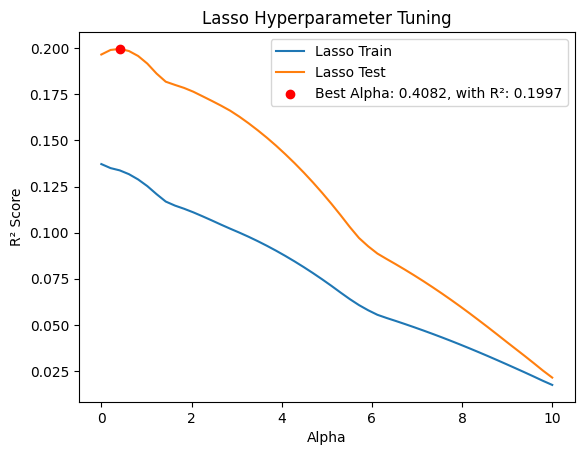

In [ ]:
train, test = HyperparameterTuning(Lasso(), xtrain, ytrain, xtest, ytest, alphas)
plt.plot(alphas, train, label="Lasso Train")
plt.plot(alphas, test, label="Lasso Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R²: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Lasso Hyperparameter Tuning")
plt.legend()
plt.show()


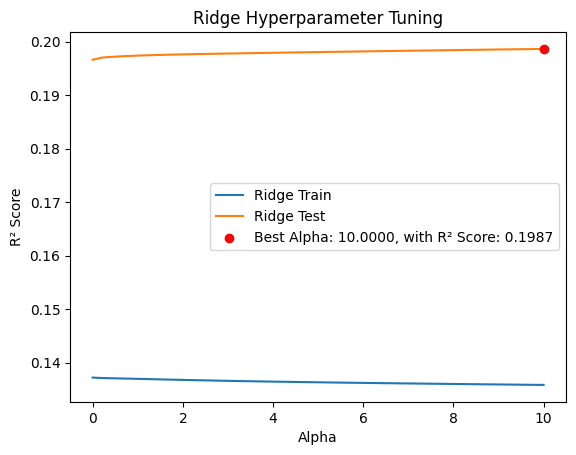

In [ ]:
train, test = HyperparameterTuning(Ridge(), xtrain, ytrain, xtest, ytest, alphas)
plt.plot(alphas, train, label="Ridge Train")
plt.plot(alphas, test, label="Ridge Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R² Score: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge Hyperparameter Tuning")
plt.legend()
plt.show()


In [ ]:
# Hyperparameter tuning for RandomForestRegressor

def HyperparameterTuningRandomForestRegressor(xtrain, ytrain, xtest, ytest, n_estimators, max_depths):

    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            train_folds = []
            test_folds = []
            for train_idx, test_idx in kf.split(xtrain):
                X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
                y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
                model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=0)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                train_folds.append(r2_score(y_train, y_pred_train))
                test_folds.append(r2_score(y_test, y_pred_test))
            train_scores.append(np.mean(train_folds))
            test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

n_estimators = [10, 25, 50, 75, 100, 150]
max_depths = [2, 5, 10, 20,50,100, None]

train, test = HyperparameterTuningRandomForestRegressor(xtrain, ytrain, xtest, ytest, n_estimators, max_depths)





## Let's see some particular values.

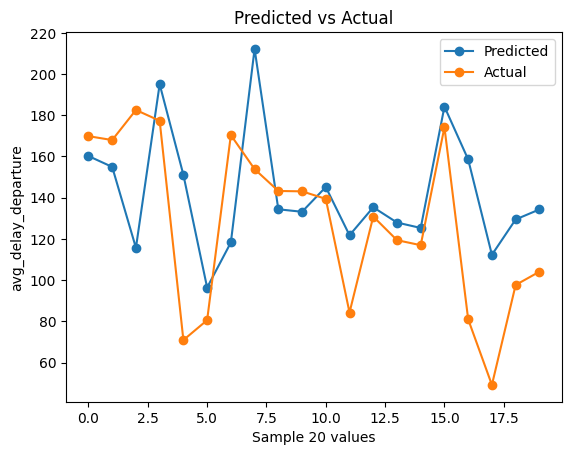

day_sin                     0.999546
day_cos                     -0.03012
holiday                            0
weekend                        False
day_after_rest                 False
avg_temperature             5.247348
avg_dewpoint                2.402652
avg_relative_humidity      82.746212
avg_precipitation           0.029924
avg_snowfall                     0.0
avg_wind_direction        182.556818
avg_wind_speed             11.337121
avg_pressure             1001.513258
Name: 1918, dtype: object


In [45]:

rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=0)
rf.fit(xtrain, ytrain)

new_x = xtest.iloc[0:20]  
new_y = ytest.iloc[0:20]

predictions = rf.predict(new_x)
comparison_df = pd.DataFrame({'Predicted': predictions,'Actual': new_y.values}, index=new_y.index)

plt.plot(predictions, label='Predicted', marker='o')
plt.plot(new_y.values, label='Actual', marker='o')
plt.title("Predicted vs Actual")
plt.xlabel("Sample 20 values")
plt.ylabel("avg_delay_departure")
plt.legend()
plt.show()

print(new_x.iloc[6])

By doing the reverse of day_sin and day_cos, we are going to have 9 October.

In [ ]:
query = """WITH DailyAverageDelays AS (
    SELECT 
        departure_date, 
        AVG(delay_arrival) AS avg_delay_arrival, 
        AVG(delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA
    GROUP BY departure_date
)
SELECT 
    departure_date, 
    avg_delay_arrival, 
    avg_delay_departure, 
    CASE 
        WHEN avg_delay_arrival >= 300 OR avg_delay_departure >= 300 THEN 1 
        ELSE 0 
    END AS delay_flag
FROM DailyAverageDelays;"""

temp =  pd.read_sql(sqla.text(query), connection)
display(temp)

In [6]:
merged_df["delay_flag"] = ((merged_df["avg_delay_arrival"] >= 300) | 
                                  (merged_df["avg_delay_departure"] >= 300)).astype(int)

display(merged_df)


,holiday,weekend,day_after_rest,avg_delay_arrival,avg_delay_departure,avg_temperature,avg_dewpoint,avg_relative_humidity,avg_precipitation,avg_snowfall,avg_wind_direction,avg_wind_speed,avg_pressure,day_sin,day_cos,delay_flag
0,2,False,False,38.000104,47.338924,6.834615,4.222308,84.692308,0.005769,0.0,187.846154,24.132693,1005.357310,1.721336e-02,0.999852,0
1,1,False,False,61.479792,69.302843,8.257252,5.640076,84.694656,0.029008,0.0,202.900763,22.245802,1000.038171,3.442161e-02,0.999407,0
2,1,False,False,131.355574,137.877869,8.838931,5.646947,81.770992,0.017557,0.0,204.809160,26.137023,1003.428245,5.161967e-02,0.998667,0
3,1,True,False,73.400835,81.274319,7.535938,4.859375,84.109375,0.000000,0.0,179.062500,19.125000,1001.156251,6.880243e-02,0.997630,0
4,1,True,False,63.745558,71.634720,4.975379,2.743182,86.128788,0.014015,0.0,206.742424,17.959091,1006.122729,8.596480e-02,0.996298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,1,False,False,115.032016,118.386998,2.355682,0.105303,88.973485,0.000000,0.0,188.662879,4.873864,1033.806809,-5.161967e-02,0.998667,0
4014,1,True,False,90.402355,96.597680,0.447727,-0.890530,91.526515,0.000000,0.0,198.060606,6.454924,1030.597722,-3.442161e-02,0.999407,0
4015,1,True,False,57.736765,65.029618,0.620833,0.399621,98.314394,0.000000,0.0,215.412879,10.555682,1031.240527,-1.721336e-02,0.999852,0
4016,1,False,False,86.974808,90.947700,2.664773,2.418182,98.026515,0.000000,0.0,207.541667,14.429545,1030.950375,6.432491e-16,1.000000,0


In [43]:
def sample_plot(xtrain , ytrain, xtest, ytest):
    rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=0)
    rf.fit(xtrain, ytrain)

    new_x = xtest.iloc[0:300]  
    new_y = ytest.iloc[0:300]

    predictions = rf.predict(new_x)
    plt.figure(figsize=(8, 6))
    plt.scatter(ytest, predictions, alpha=0.5, color='purple')
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
    plt.xlabel("Observed Delays")
    plt.ylabel("Predicted Delays")
    plt.title("Predicted vs Observed Delays")
    plt.grid(True)
    plt.show()

In [13]:
x_strike = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag"]]
y_strike = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_strike, y_strike, test_size=0.2, random_state=0)

KeyError: "['delay_flag'] not in index"

In [14]:
model_test(xtrain,xtest,ytrain,ytest)

Model RandomForestRegressor()
MSE:  1365.5771809044456
MAE:  28.37595791167683
R2:  0.5103757784423337
Model LinearRegression()
MSE:  1791.50726060904
MAE:  32.44179654664083
R2:  0.3576596327498337
Model Lasso()
MSE:  1777.4148825313273
MAE:  32.36890652651848
R2:  0.362712419031475
Model Ridge()
MSE:  1783.135742422461
MAE:  32.416517318718554
R2:  0.36066121928238315
Model SVR()
MSE:  2881.1082454235825
MAE:  37.96559509064546
R2:  -0.033014026314199585
Model DecisionTreeRegressor()
MSE:  2539.586514844181
MAE:  38.470339368381865
R2:  0.08943772069669853
Model KNeighborsRegressor()
MSE:  3709.612959193972
MAE:  42.71864994545137
R2:  -0.330072282126596


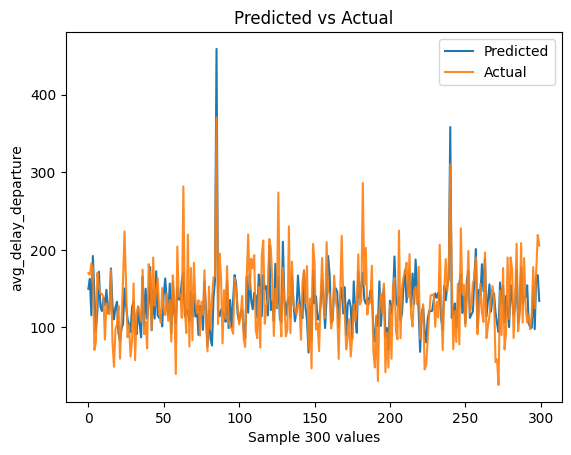

In [15]:
sample_plot(xtrain, ytrain, xtest, ytest)


In [51]:
ones_indices = merged_df[merged_df["delay_flag"] == 1].index

num_to_change = int(len(ones_indices) * 0.1)
random_indices = np.random.choice(ones_indices, size=num_to_change, replace=False)

merged_df.loc[random_indices, "delay_flag"] = 0

In [52]:
x_strike_updated = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag"]]
y_strike_updated = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_strike_updated, y_strike_updated, test_size=0.2, random_state=0)

Model RandomForestRegressor()
MSE:  1437.6987929263503
MAE:  28.890493198981364
R2:  0.48451675806801764
Model LinearRegression()
MSE:  1820.4465757883618
MAE:  32.6266431381883
R2:  0.3472835149695829
Model Lasso()
MSE:  1845.9396869274165
MAE:  32.722396302538066
R2:  0.33814302487419656
Model Ridge()
MSE:  1816.0804305297013
MAE:  32.622098639669346
R2:  0.3488489852362019
Model SVR()
MSE:  2881.1083869990957
MAE:  37.96559539558054
R2:  -0.03301407707573922
Model DecisionTreeRegressor()
MSE:  2746.7642813975167
MAE:  39.12711949093953
R2:  0.015154659957833494
Model KNeighborsRegressor()
MSE:  3709.612959193972
MAE:  42.71864994545137
R2:  -0.330072282126596


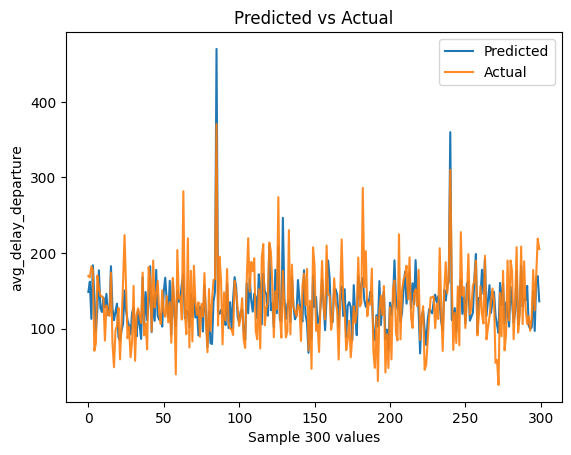

In [53]:
model_test(xtrain,xtest,ytrain,ytest)
sample_plot(xtrain, ytrain, xtest, ytest)

In [13]:
merged_df["delay_flag_2"] = np.select(
    [
        (merged_df["avg_delay_arrival"] < 225) & (merged_df["avg_delay_departure"] < 225),  # Condition for 0
        ((merged_df["avg_delay_arrival"] >= 225) & (merged_df["avg_delay_arrival"] <= 300)) | 
        ((merged_df["avg_delay_departure"] >= 225) & (merged_df["avg_delay_departure"] <= 300)),  # Condition for 1
        (merged_df["avg_delay_arrival"] > 300) | (merged_df["avg_delay_departure"] > 300)  # Condition for 2
    ],
    [0, 1, 2],  # Assign corresponding values
)

delay_flag_counts = merged_df["delay_flag_2"].value_counts()
delay_flag_counts.columns = ["delay_flag_2", "count"]


print(delay_flag_counts)

0    3809
1     151
2      58
Name: delay_flag_2, dtype: int64


In [14]:
x_delayflag = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag_2"]]
y_delayflag = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_delayflag, y_delayflag, test_size=0.2, random_state=0)

Model RandomForestRegressor()
MSE:  2115.8933306369654
MAE:  32.27132036718549
R2:  0.24135183320357922
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.1445491984764
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4489.257989703609
MAE:  45.737311765844325
R2:  -0.6096120228988866
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


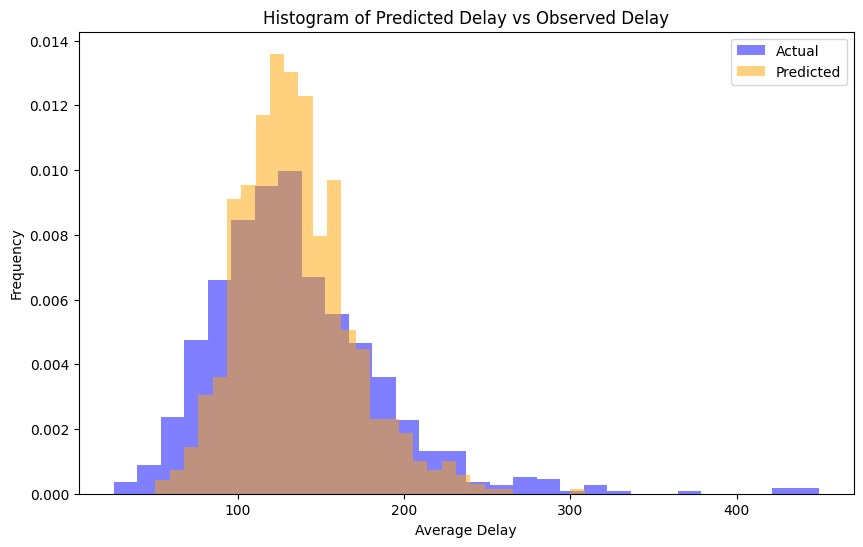

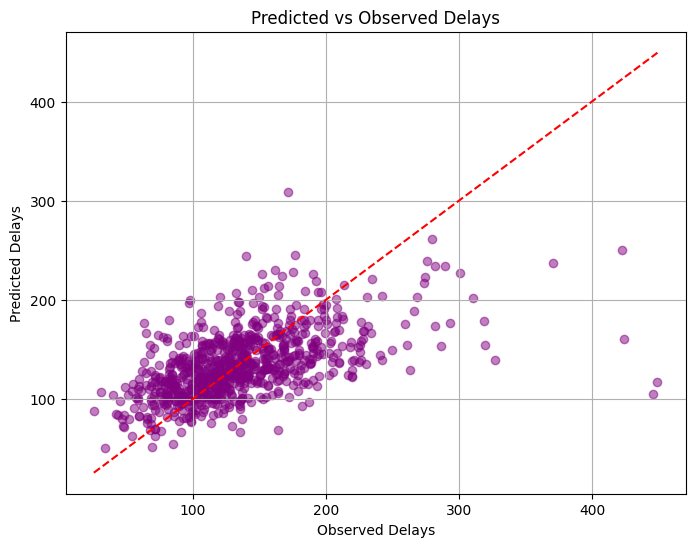

In [47]:
model_test(xtrain,xtest,ytrain,ytest)
pred_hist(xtrain, ytrain, xtest, ytest)

# Updated Regression From Feedback

### Removing the days with huge delays for training.

In [12]:
def pred_hist(xtrain, ytrain, xtest, ytest):
    rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=0)
    rf.fit(xtrain, ytrain)


    predictions = rf.predict(xtest)
    plt.figure(figsize=(10, 6))

    plt.hist(ytest, bins=30, alpha=0.5, label='Actual', color='blue', density=True)
    plt.hist(predictions, bins=30, alpha=0.5, label='Predicted', color='orange', density=True)

    plt.xlabel('Average Delay')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Delay vs Observed Delay')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(ytest, predictions, alpha=0.5, color='purple')
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
    plt.xlabel("Observed Delays")
    plt.ylabel("Predicted Delays")
    plt.title("Predicted vs Observed Delays")
    plt.grid(True)
    plt.show()

    

In [51]:
regular = merged_df[(merged_df['avg_delay_departure'] <= 250) | (merged_df['avg_delay_arrival'] <= 250)]

x_regular = regular[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_regular = regular["avg_delay_arrival"]

xtrain, xtest, ytrain, ytest = train_test_split(x_regular, y_regular, test_size=0.2, random_state=0)


Model RandomForestRegressor()
MSE:  1223.3848343326413
MAE:  27.140254291236744
R2:  0.4159681984007344
Model LinearRegression()
MSE:  1598.1341698220435
MAE:  31.46271021312191
R2:  0.23706657773989415
Model Lasso()
MSE:  1660.3696096769645
MAE:  32.01667785490806
R2:  0.2073559952300008
Model Ridge()
MSE:  1591.3261159367248
MAE:  31.379393425373785
R2:  0.24031667522716327
Model SVR()
MSE:  2111.016123462665
MAE:  36.502151715474994
R2:  -0.0077781865454849
Model DecisionTreeRegressor()
MSE:  2401.4166022813856
MAE:  36.877961640885886
R2:  -0.14641249855435134
Model KNeighborsRegressor()
MSE:  2271.385767252244
MAE:  38.47242457861517
R2:  -0.08433706593959855


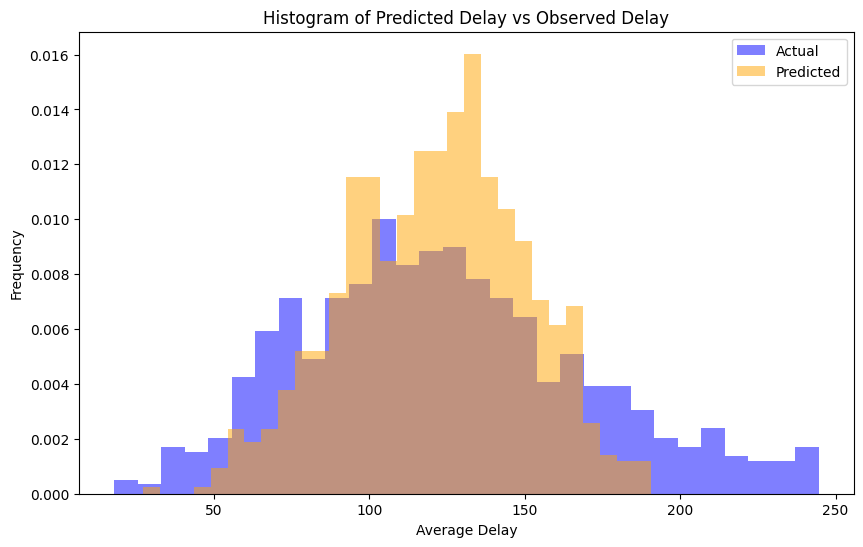

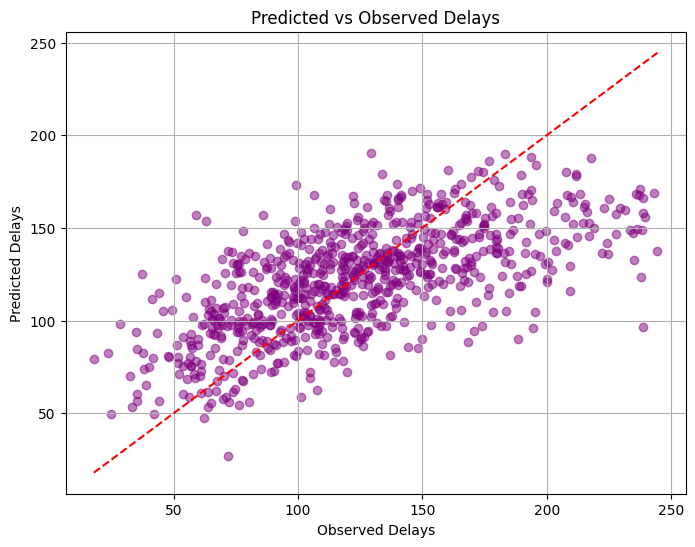

In [52]:
model_test(xtrain,xtest,ytrain,ytest)
pred_hist(xtrain, ytrain, xtest, ytest)

# MLP implementation

In [15]:
xtrain = xtrain.apply(pd.to_numeric, errors="coerce")
xtrain["weekend"] = xtrain["weekend"].astype(int)
xtrain["day_after_rest"] = xtrain["day_after_rest"].astype(int)

In [89]:
X_tensor = torch.tensor(xtrain.values, dtype=torch.float32)
y_tensor = torch.tensor(ytrain.values, dtype=torch.float32).view(-1, 1)  

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, 1024)  
        self.output = nn.Linear(1024, 1)  
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.hidden(x))  # Hidden layer
        x = self.output(x)
        return x

input_size = xtrain.shape[1]  
model = MLP(input_size)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10000
for epoch in range(epochs):
    model.train()

    y_pred = model(X_tensor)

    loss = criterion(y_pred, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval() 
with torch.no_grad():
    predictions = model(X_tensor)
    print("Predictions:\n", predictions)
    print("True values:\n", y_tensor)

predictions = predictions.numpy().flatten()
y_tensor = y_tensor.numpy().flatten()

Epoch 0, Loss: 37722.3320
Epoch 100, Loss: 1869.1064
Epoch 200, Loss: 1835.8582
Epoch 300, Loss: 1800.7538
Epoch 400, Loss: 1771.3149
Epoch 500, Loss: 1741.9740
Epoch 600, Loss: 1708.2314
Epoch 700, Loss: 1671.2585
Epoch 800, Loss: 1632.9498
Epoch 900, Loss: 1595.4343
Epoch 1000, Loss: 1562.0692
Epoch 1100, Loss: 1535.6123
Epoch 1200, Loss: 1515.3225
Epoch 1300, Loss: 1495.4391
Epoch 1400, Loss: 1482.1918
Epoch 1500, Loss: 1472.1929
Epoch 1600, Loss: 1464.4711
Epoch 1700, Loss: 1457.5579
Epoch 1800, Loss: 1451.4600
Epoch 1900, Loss: 1448.1770
Epoch 2000, Loss: 1438.0074
Epoch 2100, Loss: 1429.0173
Epoch 2200, Loss: 1422.1769
Epoch 2300, Loss: 1415.2827
Epoch 2400, Loss: 1407.4650
Epoch 2500, Loss: 1399.2107
Epoch 2600, Loss: 1396.6102
Epoch 2700, Loss: 1383.7720
Epoch 2800, Loss: 1380.0233
Epoch 2900, Loss: 1386.0621
Epoch 3000, Loss: 1363.9508
Epoch 3100, Loss: 1358.6934
Epoch 3200, Loss: 1352.6656
Epoch 3300, Loss: 1358.9027
Epoch 3400, Loss: 1346.4828
Epoch 3500, Loss: 1340.2438
Epo

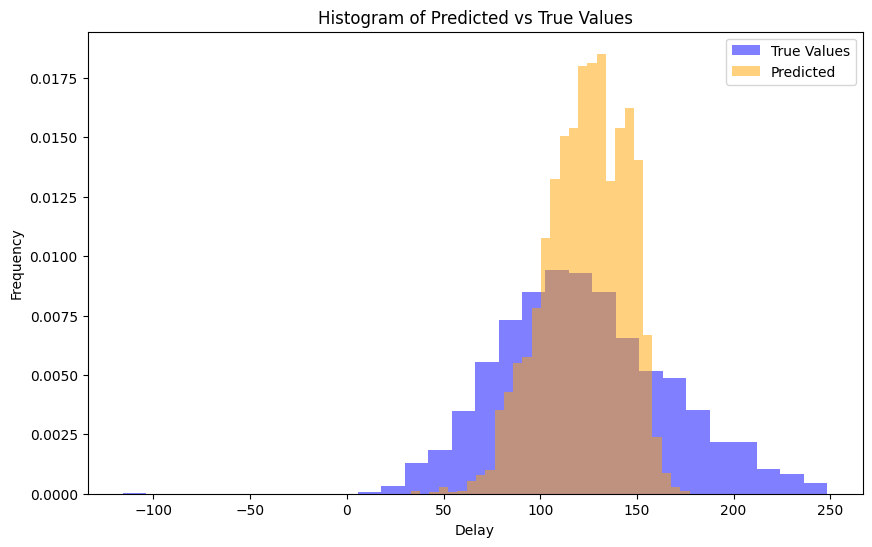

0.2502235187431885


In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(y_tensor, bins=30, alpha=0.5, label='Observed Delays', color='blue', density=True)
plt.hist(predictions, bins=30, alpha=0.5, label='Predicted', color='orange', density=True)

plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.title('MLP Predicted vs Observed Delays')
plt.legend()


plt.show()
print(r2_score(y_tensor, predictions))

# Try with XGBoost

R² Score: 0.4292
Mean Squared Error: 1000.18
Mean Absolute Error: 24.93


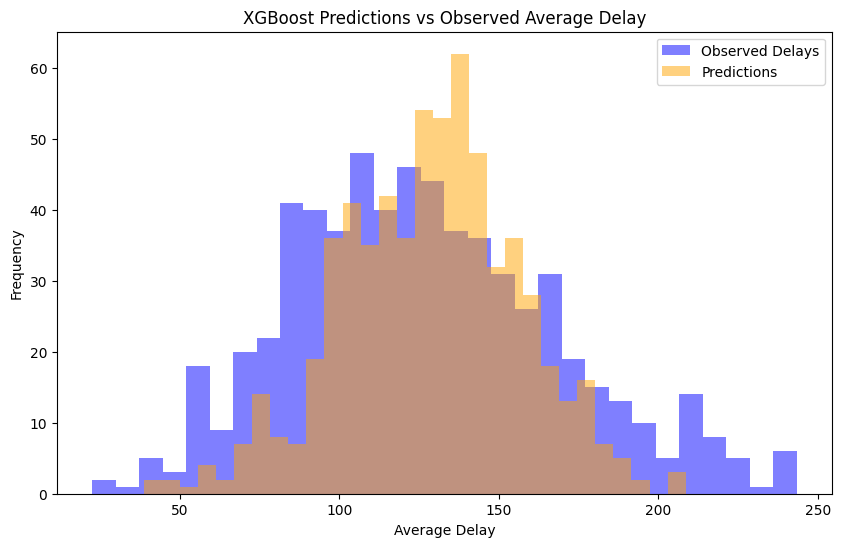

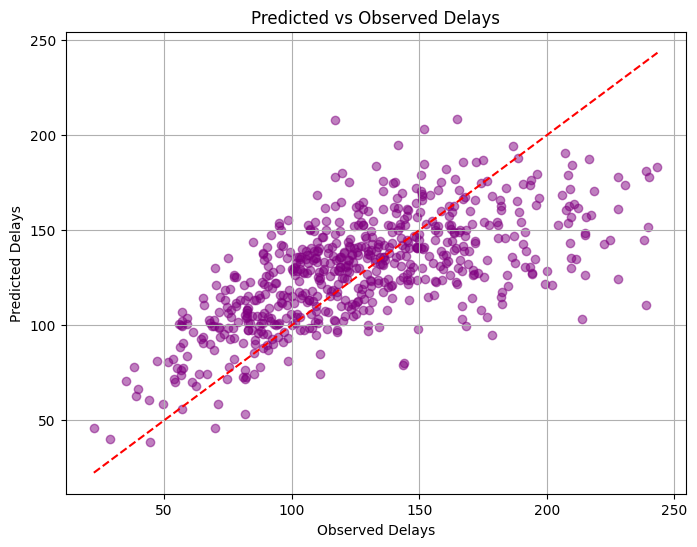

In [23]:
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(xtrain, ytrain)

preds = model.predict(xtest)

r2 = r2_score(ytest, preds)
mse = mean_squared_error(ytest, preds)
mae = mean_absolute_error(ytest, preds)
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
plt.figure(figsize=(10, 6))
plt.hist(ytest, bins=30, alpha=0.5, label='Observed Delays', color='blue')
plt.hist(preds, bins=30, alpha=0.5, label='Predictions', color='orange')
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.title('XGBoost Predictions vs Observed Average Delay')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(ytest, preds, alpha=0.5, color='purple')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.xlabel("Observed Delays")
plt.ylabel("Predicted Delays")
plt.title("Predicted vs Observed Delays")
plt.grid(True)
plt.show()

### Hyperparameters tuning for xgboost

In [23]:
xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3, 0.001]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='r2', 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(xtrain, ytrain)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation R²:", grid_search.best_score_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation R²: 0.34150776116403114


In [24]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(xtest)
test_r2 = r2_score(ytest, y_pred)

print(f"Test R² Score: {test_r2:.4f}")

Test R² Score: 0.4027


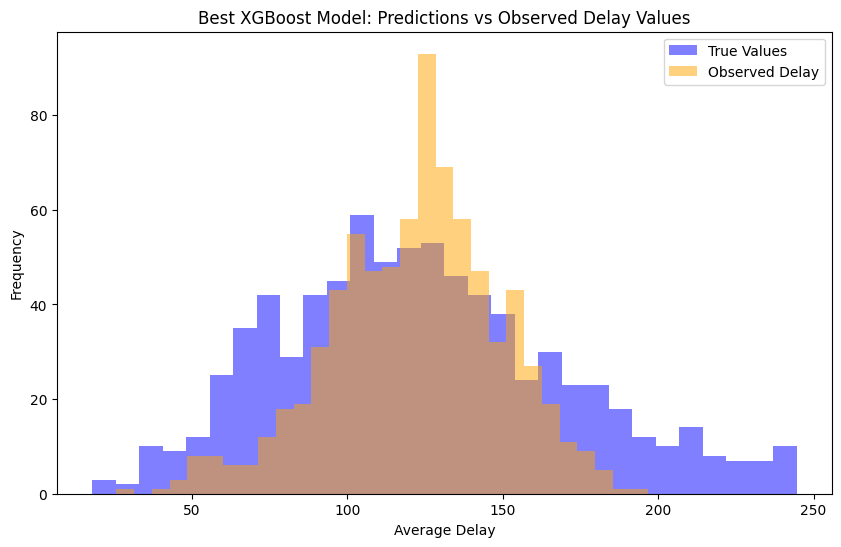

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(ytest, bins=30, alpha=0.5, label="True Values", color='blue')
plt.hist(y_pred, bins=30, alpha=0.5, label="Observed Delay", color='orange')
plt.title("Best XGBoost Model: Predictions vs Observed Delay Values")
plt.xlabel("Average Delay")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Modify test and train test by specific years

the train set will be before 2020, while the test set will be post 2022. 2020 and 2021 were omitted due to covid

In [9]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_train = merged_df[merged_df['date'] < '2020-01-01']
merged_test = merged_df[merged_df['date'] >= '2022-01-01']

merged_train['date'] = merged_train['date'].dt.dayofyear
merged_test['date'] = merged_test['date'].dt.dayofyear

merged_train['day_sin'] = np.sin(2 * np.pi * merged_train['date'] / 365)
merged_train['day_cos'] = np.cos(2 * np.pi * merged_train['date'] / 365)

merged_test['day_sin'] = np.sin(2 * np.pi * merged_test['date'] / 365)
merged_test['day_cos'] = np.cos(2 * np.pi * merged_test['date'] / 365)

merged_train.drop(columns=['date'], inplace=True)
merged_test.drop(columns=['date'], inplace=True)

print(merged_train.shape)
print(merged_test.shape)

(2191, 15)
(1065, 15)


C:\Users\Manuel\AppData\Local\Temp\ipykernel_8948\495035931.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_train['date'] = merged_train['date'].dt.dayofyear
C:\Users\Manuel\AppData\Local\Temp\ipykernel_8948\495035931.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test['date'] = merged_test['date'].dt.dayofyear
C:\Users\Manuel\AppData\Local\Temp\ipykernel_8948\495035931.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [54]:
xtrain = merged_train[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
ytrain = merged_train["avg_delay_departure"]

xtest = merged_test[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
ytest = merged_test["avg_delay_departure"]


Model RandomForestRegressor()
MSE:  3609.195745840329
MAE:  37.813505772547934
R2:  -0.05773282604705132
Model LinearRegression()
MSE:  3437.934294884943
MAE:  37.198043733161775
R2:  -0.007541905058424669
Model Lasso()
MSE:  3367.7140293822276
MAE:  35.376589786518984
R2:  0.013037272438823466
Model Ridge()
MSE:  3401.369797318737
MAE:  36.7054427113967
R2:  0.003173908676052828


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+04, tolerance: 1.318e+03
  model = cd_fast.enet_coordinate_descent(


Model SVR()
MSE:  3702.502682044077
MAE:  37.86901779674591
R2:  -0.08507792347889032
Model DecisionTreeRegressor()
MSE:  6934.584570129279
MAE:  54.3952592285222
R2:  -1.0322914719376977
Model KNeighborsRegressor()
MSE:  4209.530492366479
MAE:  41.077243206131165
R2:  -0.23367057305043515


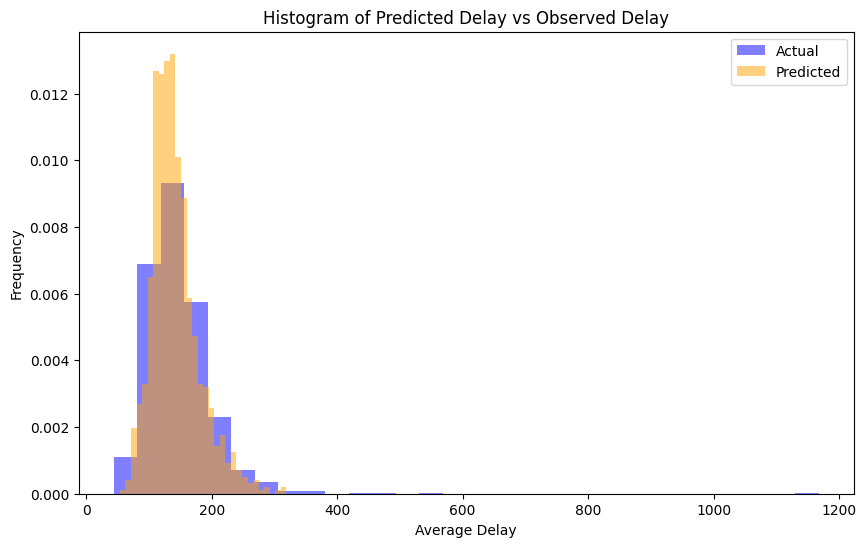

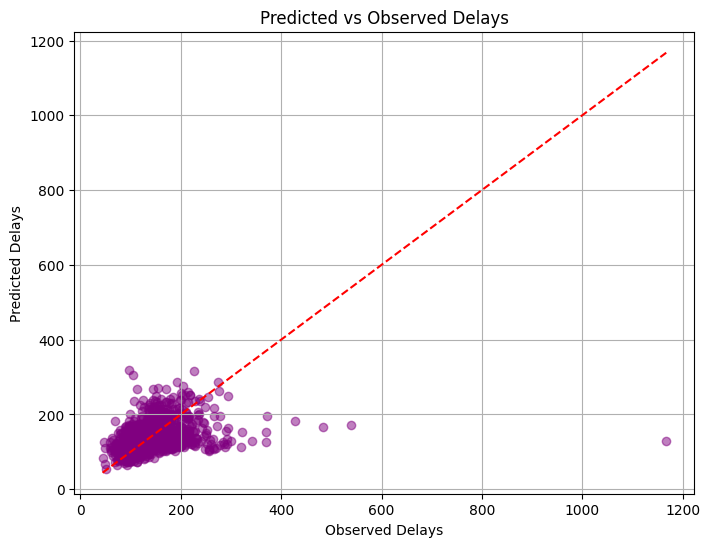

In [55]:
model_test(xtrain,xtest,ytrain,ytest)
pred_hist(xtrain,ytrain,xtest,ytest)

### Now trying without high delays

In [10]:
dep_95 = merged_train['avg_delay_departure'].quantile(0.95)
arr_95 = merged_train['avg_delay_arrival'].quantile(0.95)

regular_train = merged_train[(merged_train['avg_delay_departure'] <= dep_95) | (merged_train['avg_delay_arrival'] <= arr_95)]
regular_test = merged_test[(merged_test['avg_delay_departure'] <= dep_95) | (merged_test['avg_delay_arrival'] <= arr_95)]

xtrain = regular_train[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
ytrain = regular_train["avg_delay_departure"]

xtest = regular_test[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
ytest = regular_test["avg_delay_departure"]


Model RandomForestRegressor()
MSE:  1373.9278390051188
MAE:  29.24434039461836
R2:  0.07203829003690554
Model LinearRegression()
MSE:  1454.0722938802685
MAE:  29.83465342091744
R2:  0.01790809245399827
Model Lasso()
MSE:  1547.2789273172907
MAE:  30.334599378324732
R2:  -0.04504440365871809
Model Ridge()
MSE:  1454.0268711808292
MAE:  29.809587410697997
R2:  0.01793877130382282
Model SVR()
MSE:  1630.7735544573775
MAE:  32.38494495974812
R2:  -0.10143733403980004
Model DecisionTreeRegressor()
MSE:  2336.3655533645756
MAE:  38.297955294785076
R2:  -0.5779997409245201
Model KNeighborsRegressor()
MSE:  1704.5724644735142
MAE:  33.046019748551956
R2:  -0.1512817005252889


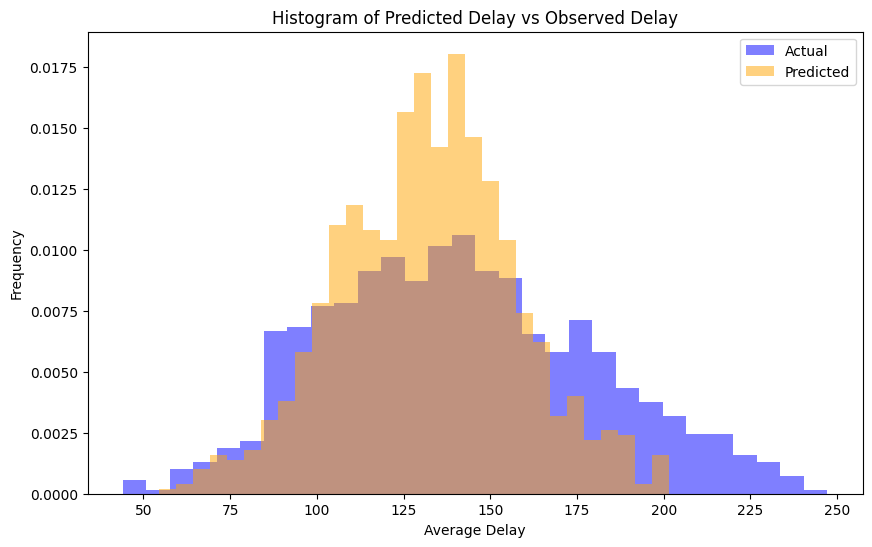

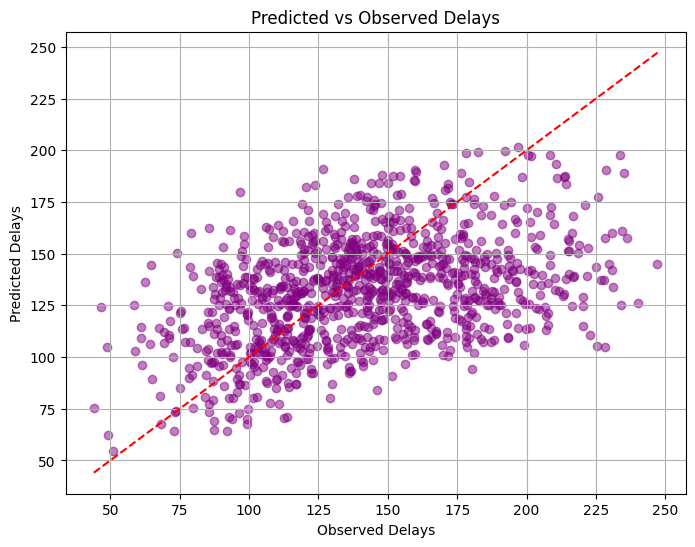

In [13]:
model_test(xtrain,xtest,ytrain,ytest)
pred_hist(xtrain,ytrain,xtest,ytest)

### MLP

In [43]:
xtrain["weekend"] = xtrain["weekend"].astype(int)
xtrain["day_after_rest"] = xtrain["day_after_rest"].astype(int)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_20016\1725149524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain["weekend"] = xtrain["weekend"].astype(int)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_20016\1725149524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain["day_after_rest"] = xtrain["day_after_rest"].astype(int)


In [56]:
X_tensor = torch.tensor(xtrain.values, dtype=torch.float32)
y_tensor = torch.tensor(ytrain.values, dtype=torch.float32).view(-1, 1)  

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, 1024)  
        self.output = nn.Linear(1024, 1)  
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.hidden(x))  # Hidden layer
        x = self.output(x)
        return x

input_size = xtrain.shape[1]  
model = MLP(input_size)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 5000
for epoch in range(epochs):
    model.train()

    y_pred = model(X_tensor)

    loss = criterion(y_pred, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval() 
with torch.no_grad():
    predictions = model(X_tensor)
    print("Predictions:\n", predictions)
    print("True values:\n", y_tensor)

predictions = predictions.numpy().flatten()
y_tensor = y_tensor.numpy().flatten()

Epoch 0, Loss: 41599.1172
Epoch 100, Loss: 1619.5275
Epoch 200, Loss: 1588.1904
Epoch 300, Loss: 1554.3917
Epoch 400, Loss: 1518.3517
Epoch 500, Loss: 1479.7269
Epoch 600, Loss: 1435.4149
Epoch 700, Loss: 1380.3203
Epoch 800, Loss: 1323.9109
Epoch 900, Loss: 1268.8947
Epoch 1000, Loss: 1227.2449
Epoch 1100, Loss: 1195.6797
Epoch 1200, Loss: 1173.0748
Epoch 1300, Loss: 1157.1387
Epoch 1400, Loss: 1144.8379
Epoch 1500, Loss: 1136.0580
Epoch 1600, Loss: 1127.9386
Epoch 1700, Loss: 1120.9890
Epoch 1800, Loss: 1114.6943
Epoch 1900, Loss: 1114.4934
Epoch 2000, Loss: 1102.9362
Epoch 2100, Loss: 1093.4957
Epoch 2200, Loss: 1083.9109
Epoch 2300, Loss: 1092.3932
Epoch 2400, Loss: 1070.1450
Epoch 2500, Loss: 1063.9275
Epoch 2600, Loss: 1055.6307
Epoch 2700, Loss: 1050.2701
Epoch 2800, Loss: 1047.9731
Epoch 2900, Loss: 1037.7544
Epoch 3000, Loss: 1030.0088
Epoch 3100, Loss: 1024.1146
Epoch 3200, Loss: 1014.5108
Epoch 3300, Loss: 1016.9731
Epoch 3400, Loss: 1004.0374
Epoch 3500, Loss: 1003.0151
Epo

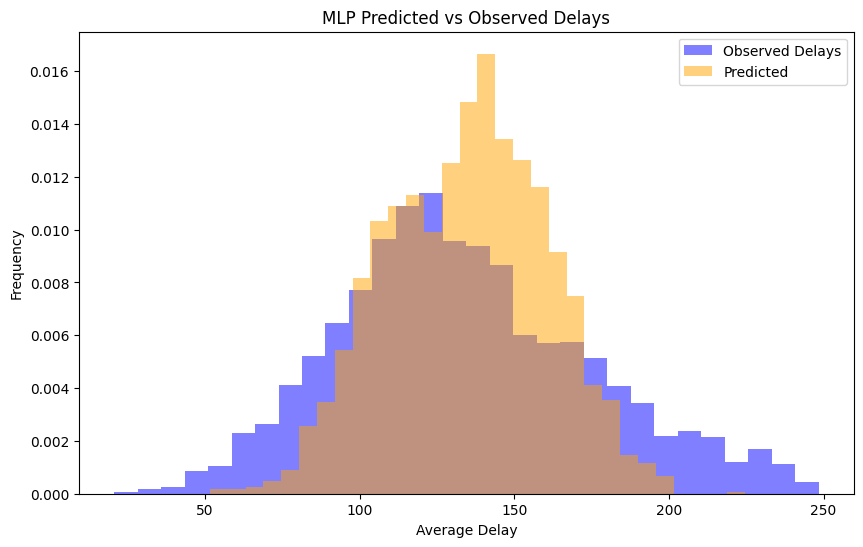

0.4333104085724736


In [57]:
plt.figure(figsize=(10, 6))

plt.hist(y_tensor, bins=30, alpha=0.5, label='Observed Delays', color='blue', density=True)
plt.hist(predictions, bins=30, alpha=0.5, label='Predicted', color='orange', density=True)

plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.title('MLP Predicted vs Observed Delays')
plt.legend()


plt.show()
print(r2_score(y_tensor, predictions))

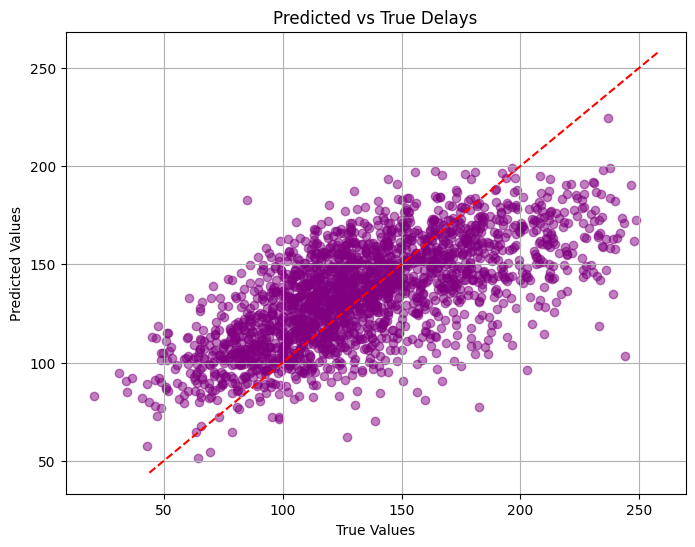

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(y_tensor, predictions, alpha=0.5, color='purple')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Delays")
plt.grid(True)
plt.show()

### XGBoost

In [7]:
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(xtrain, ytrain)

preds = model.predict(xtest)

r2 = r2_score(ytest, preds)
mse = mean_squared_error(ytest, preds)
mae = mean_absolute_error(ytest, preds)
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
plt.figure(figsize=(10, 6))
plt.hist(ytest, bins=30, alpha=0.5, label='Observed Delays', color='blue')
plt.hist(preds, bins=30, alpha=0.5, label='Predictions', color='orange')
plt.xlabel('Average Delay')
plt.ylabel('Frequency')
plt.title('XGBoost Predictions vs Observed Average Delay')
plt.legend()
plt.show()

NameError: name 'XGBRegressor' is not defined

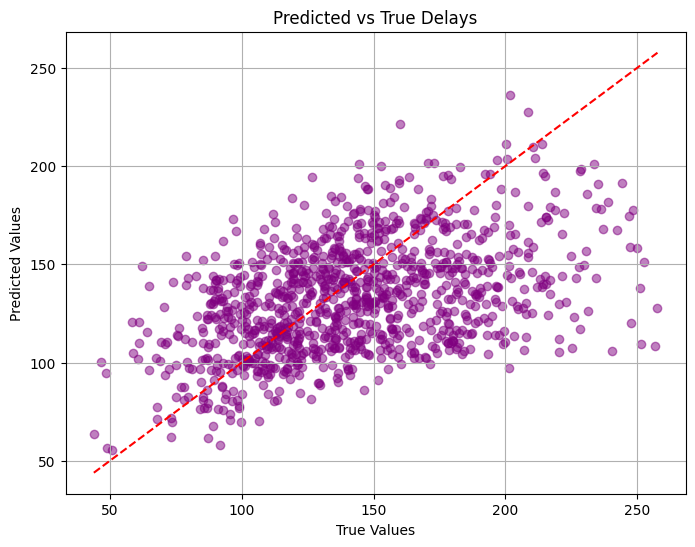

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, preds, alpha=0.5, color='purple')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Delays")
plt.grid(True)
plt.show()

# Updated with folds over years

In [27]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df[(merged_df['date'] < '2020-01-01') | (merged_df['date'] >= "2022-01-01")]
temp = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * temp/365)
merged_df['day_cos'] = np.cos(2 * np.pi * temp/365)

print(merged_df.shape)
print(merged_df.head())

(3287, 16)
        date  holiday  weekend  day_after_rest  avg_delay_arrival  \
0 2014-01-01        2    False           False          38.000104   
1 2014-01-02        1    False           False          61.479792   
2 2014-01-03        1    False           False         131.355574   
3 2014-01-04        1     True           False          73.400835   
4 2014-01-05        1     True           False          63.745558   

   avg_delay_departure  avg_temperature  avg_dewpoint  avg_relative_humidity  \
0            47.338924         6.834615      4.222308              84.692308   
1            69.302843         8.257252      5.640076              84.694656   
2           137.877869         8.838931      5.646947              81.770992   
3            81.274319         7.535938      4.859375              84.109375   
4            71.634720         4.975379      2.743182              86.128788   

   avg_precipitation  avg_snowfall  avg_wind_direction  avg_wind_speed  \
0           0.00576

In [40]:
selected_features = ["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]
r2_scores = []
mae_scores = []

n_splits = 10
start_date = merged_df["date"].min() 
train_start_date = start_date
train_end_date = pd.Timestamp(start_date) + pd.DateOffset(years=1) 

for i in range(n_splits):
    train = merged_df[(merged_df["date"] >= train_start_date) & (merged_df['date'] < train_end_date)]

    test_end_date = train_end_date + pd.DateOffset(years=1) 
    test = merged_df[(merged_df['date'] >= train_end_date) & (merged_df["date"] < test_end_date)]

    X_train = train[selected_features]
    print(X_train)
    y_train = train["avg_delay_departure"]
    X_test = test[selected_features]
    y_test = test["avg_delay_departure"]

    if train.empty or test.empty:
        train_end_date = train_end_date + pd.DateOffset(years=1)
        continue

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"Fold {i+1} R²: {r2:.2f}, MAE: {mae:.2f}")
    train_end_date = train_end_date + pd.DateOffset(years=1)

print(f"\nAverage R² over {n_splits} folds: {sum(r2_scores)/len(r2_scores):.2f}")
print(f"Average MAE over {n_splits} folds: {sum(mae_scores)/len(mae_scores):.2f}")

          day_sin   day_cos  holiday  weekend  day_after_rest  \
0    1.721336e-02  0.999852        2    False           False   
1    3.442161e-02  0.999407        1    False           False   
2    5.161967e-02  0.998667        1    False           False   
3    6.880243e-02  0.997630        1     True           False   
4    8.596480e-02  0.996298        1     True           False   
..            ...       ...      ...      ...             ...   
360 -6.880243e-02  0.997630        1     True           False   
361 -5.161967e-02  0.998667        1     True           False   
362 -3.442161e-02  0.999407        1    False           False   
363 -1.721336e-02  0.999852        1    False           False   
364  6.432491e-16  1.000000        1    False           False   

     avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0           6.834615      4.222308              84.692308           0.005769   
1           8.257252      5.640076              84.694656  